### 1D conv model  

Production run on 3 outlier clipping models  

for BRCA and BLCA

From 1Dmodel_00.ipynb
    Deconstruction notes and 2D to 1D conversion

data:
../a_data_structure/normalized_data/flat

In [ ]:
ls ../a_data_structure/normalized_data/flat

In [5]:
# 7 files per 2 cancers, 14 possible model runs 
7*2

14

In [ ]:
# start 500 BLCA - fail, loss explodes after 7 or 8 epochs
# skip BRCA fine tune, go to BRCA blank run, need RobustScaler

In [1]:
%whos

Interactive namespace is empty.


In [2]:
# blank run START, Data import and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
cohort  = 'BLCA'

In [19]:
cohort  = 'BRCA'

In [ ]:
otlr_cut = '100k'

In [4]:
otlr_cut = '10k' # starting the BRCA blank run, only run with these vars defined from the start
# check the write-out files - three loss and three sets of decoded files

In [ ]:
otlr_cut = '1k' # restart kernel, run BLCA blank

In [ ]:
otlr_cut = '500' # starting BLCA blank run

In [20]:
# read pre-normalized data
train_norm = pd.read_csv('../a_data_structure/normalized_data/flat/'+cohort+'_X_train_flat_'+otlr_cut+'_otlr_cut_MinMax.tsv',
                  sep = '\t',
                   index_col = 0)

In [21]:
test_norm = pd.read_csv('../a_data_structure/normalized_data/flat/'+cohort+'_X_test_flat_'+otlr_cut+'_otlr_cut_MinMax.tsv',
                  sep = '\t',
                   index_col = 0)

In [22]:
train_norm.shape

(746, 20530)

In [23]:
test_norm.shape

(249, 20530)

In [24]:
train_norm_arr = train_norm.to_numpy()
train_norm_arr_exp = np.expand_dims(train_norm_arr, axis=-1)

In [25]:
train_norm_arr.shape

(746, 20530)

In [26]:
train_norm_arr_exp.shape

(746, 20530, 1)

In [27]:
test_norm_arr = test_norm.to_numpy()
test_norm_arr_exp = np.expand_dims(test_norm_arr, axis=-1)

In [13]:
# skip for fine-tune run
# 1Dconv, do not rebuild in memory - build from fresh kernel only (blank run)

latent_dim = 100

import tensorflow as tf; tf.compat.v1.disable_eager_execution()

from keras import backend as K
from keras.layers import (Input, # want float.64 to go into this layer, two input layers (enc and dec)
                          Conv1D,
                          Dense,
                          Conv1DTranspose,
                          Flatten,
                          Lambda,
                          Reshape)
from keras.models import Model

from keras.losses import binary_crossentropy

print('libraries done')

tf.executing_eagerly()

def compute_latent(x):
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

def kl_reconstruction_loss(true, pred):                                                  
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred))
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

encoder_input = Input(shape=(train_norm.shape[1],1,))

encoder_conv = Conv1D(filters=8,
                      kernel_size=3,
                      activation='relu',
                      padding='same')(encoder_input)

encoder_conv = Conv1D(filters=16,
                      kernel_size=3,
                      padding='same',
                      activation='relu')(encoder_conv)

encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
                    
conv_shape = K.int_shape(encoder_conv)

# Decoder start
decoder_input = Input(shape=(latent_dim,))

decoder = Dense(conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2]))(decoder)

decoder_conv = Conv1DTranspose(filters=16,
                      kernel_size=3,
                      padding='same',
                      activation='relu')(decoder)

decoder_conv = Conv1DTranspose(filters=8,
                      kernel_size=3,
                      activation='relu',
                      padding='same')(decoder_conv)

decoder_conv = Conv1DTranspose(filters=1,
                      kernel_size=3,
                      activation='relu',
                      padding='same')(decoder_conv)

encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)  # blank model set for (pre)training
print('model built')

2022-10-13 14:53:38.740580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


libraries done
model built


In [ ]:
encoder.summary() # kernel restart, Layer names reset, shapes same

In [ ]:
decoder.summary() # kernel restart

In [ ]:
# last number is number of filters

In [ ]:
tf.keras.utils.plot_model(
    encoder,
    show_shapes=True,
    to_file='./loss_curves_ignored/1D_model_r0.png')

In [ ]:
tf.keras.utils.plot_model(
    encoder,
    show_shapes=True,
    to_file='./loss_curves_ignored/1D_enc_v3.png')

In [ ]:
tf.keras.utils.plot_model(
    decoder,
    show_shapes=True,
    to_file='./loss_curves_ignored/1D_dec_model_r0.png')

In [ ]:
# tuning thoughts
# try with batch size turned down

In [14]:
epochs = 15         # blank run
version = '1Dmodel.ipynb'
date = '2022-10-13' # blank run
batch_size = 32     # blank run

In [15]:
epochs = 5 # turn down blca pretrain at 10k,
            # end otlr cut series, for template RobustScaler

In [16]:
epochs = 10 # fine tune, overwrite on BRCA 500, expecting blow up

In [28]:
epochs = 15 # fine tune BRCA 10k, erratic pre-train cycles on BLCA

In [ ]:
            # fine tune, need to fix, using cohort differently now
cohort = 'BRCA_fine_tune'

In [29]:
cohort, otlr_cut # This is going to the fit function

('BRCA', '10k')

In [30]:
# fit, restart kernel and recompile model between runs; direct fit for BRCA fast follow

history = vae.fit(x=train_norm_arr_exp, y=train_norm_arr_exp, epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(test_norm_arr_exp, test_norm_arr_exp))

Train on 746 samples, validate on 249 samples
Epoch 1/15
746/746 [==============================] - 19s 25ms/sample - loss: 619.0847 - val_loss: 938.7218
Epoch 2/15
746/746 [==============================] - 20s 27ms/sample - loss: 512.1128 - val_loss: 1498.4901
Epoch 3/15
746/746 [==============================] - 20s 27ms/sample - loss: 455.9165 - val_loss: 5445.8299
Epoch 4/15
746/746 [==============================] - 21s 28ms/sample - loss: 419.2608 - val_loss: 6513.9572
Epoch 5/15
746/746 [==============================] - 20s 27ms/sample - loss: 392.0370 - val_loss: 6449.5495
Epoch 6/15
746/746 [==============================] - 19s 26ms/sample - loss: 367.5270 - val_loss: 38984.2085
Epoch 7/15
746/746 [==============================] - 19s 26ms/sample - loss: 344.7604 - val_loss: 12409.4341
Epoch 8/15
746/746 [==============================] - 20s 26ms/sample - loss: 190.6136 - val_loss: 1524.7403
Epoch 9/15
746/746 [==============================] - 19s 26ms/sample - loss: 38.

In [31]:
pwd

'/Users/karlberb/Desktop/RNB00978/sample_count/sample_gen/synthetic_TCGA_data_gen/b_model'

In [ ]:
# Try adding 15k, 5k (?) - secondary priority to RobustScaler

In [ ]:
# BRCA blank run loss stepping down within epochs

# pre train epochs seems too much at 20
# cutting outliers feels injection of artificial signal
    # without a doubt, this is a crude technical artifact
# need a focused RobustScaler set

In [17]:
otlr_cut, cohort # completed run variable check for file naming

('1k', 'BRCA')

In [19]:
otlr_cut, cohort # completed run variable check for file naming

('500', 'BRCA')

In [20]:
otlr_cut, cohort # completed run variable check for file naming

('100k', 'BRCA')

In [15]:
otlr_cut, cohort # 5 epoch pretrain test

('10k', 'BLCA')

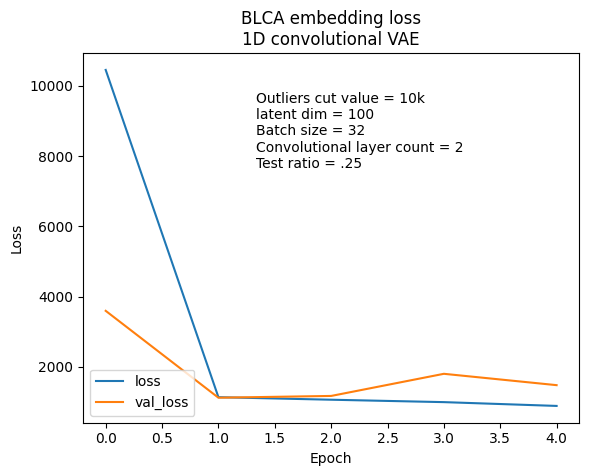

In [18]:
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.title(cohort+' embedding loss\n1D convolutional VAE'
          # ' pre-train\n'+
         )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate('Outliers cut value = '+otlr_cut+'\nlatent dim = '+
             str(latent_dim)+'\nBatch size = '+str(batch_size)+
             '\nConvolutional layer count = 2\nTest ratio = .25',
            xy=(.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            # fontsize=20
            )

plt.legend(loc="lower left")
plt.savefig('loss_curves_ignored/'+cohort+'_'+
            # '_pretrain_'+
            otlr_cut+'_outlier_cut_'+
            str(epochs)+'_epochs_v2_'+
            str(latent_dim)+'_latent_dim_'+
            date+'_'+version+'.png')

In [20]:
trn_ltnt = encoder.predict(train_norm_arr_exp)

/Users/karlberb/Desktop/RNB00978/sample_count/sample_gen/dense_layer/dense_full_env_00/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [26]:
tst_ltnt = encoder.predict(test_norm_arr_exp)

In [27]:
trn_dec = decoder.predict(trn_ltnt)

In [28]:
tst_dec = decoder.predict(tst_ltnt)

In [29]:
trn_decDF = pd.DataFrame(np.squeeze(trn_dec)) # hoping the labels map from the raw file, do in UMAP

In [30]:
tst_decDF = pd.DataFrame(np.squeeze(tst_dec))

In [62]:
pwd

'/Users/karlberb/Desktop/RNB00978/sample_count/sample_gen/synthetic_TCGA_data_gen/b_model'

In [63]:
ls

1Dconv_devel.ipynb   b_1Dmodel_00.ipynb   data/
1Dmodel.ipynb        b_model_02.ipynb     dec_out_ignrd/
README.txt           b_model_03.ipynb     decoded/
archive/             cvae.txt             loss_curves_ignored/


In [31]:
trn_decDF.to_csv('decoded/'+cohort+'_'+
            # '_pretrain_'+
            otlr_cut+'_outlier_cut_train_'+ # Train <------
            str(epochs)+'_epochs_'+
            str(latent_dim)+'_latent_dim_'+
            date+'_'+version+'.tsv', sep = '\t')

In [32]:
tst_decDF.to_csv('decoded/'+cohort+'_'+
            # '_pretrain_'+
            otlr_cut+'_outlier_cut_test_'+ # Test <------
            str(epochs)+'_epochs_'+
            str(latent_dim)+'_latent_dim_'+
            date+'_'+version+'.tsv', sep = '\t')

In [ ]:
otlr_cut, cohort # file written, done

In [ ]:
otlr_cut, cohort # file written, done

In [33]:
otlr_cut, cohort # file written, done

('10k', 'BRCA')

In [ ]:
# end 1k, begin 500 blank run, reset kernel

In [ ]:
# notes:

In [ ]:
# order of tuning ops:
    # right model type, VAE vs transformer
    # right layer type, 1D vs 2D conv
    # right data normalization scheme - manual outlier cut with MinMax vs. RobustScaler
    # right batch_size
    # right latent dimension
    # right number of epochs, maybe less for pre-train

In [ ]:
# Concept note:
# filters go up through encoder layers, outward in detail
# e.g. 8 first, then 16 on next layer

In [ ]:
batch_size = 64

In [ ]:
batch_size = 128

In [36]:
tst_dec.shape

(299, 20530, 1)

In [ ]:
# write 2 decoded files per outlier cut step

In [ ]:
# send to UMAP
    # Start with three bladder plots
        # 10k, 1k, 500
    # Run BRCA fine tune?
    # Run lone BRCA UMAP next

In [ ]:
# inverse of expand 